# 머신러닝을 이용한 캘리포니아의 주택 가격 예측  
설명 : 새로운 데이터가 주어졌을 때 구역의 중간주택가격(median housing price) 예측하는 모델 만들기  

- 깃허브 : https://github.com/ageron/handson-ml  
- 데이터 : 캘리포니아 주택가격 데이터(housing.csv)  
- 필요 패키지 : matplotlib, numpy, pandas, scipy, scikit-learn  


## 0. 라이브러리 장착  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 1. 데이터 가져오기  

In [2]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [5]:
fetch_housing_data()

In [4]:
def load_housing_data(housing_path = HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)    

In [5]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [8]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


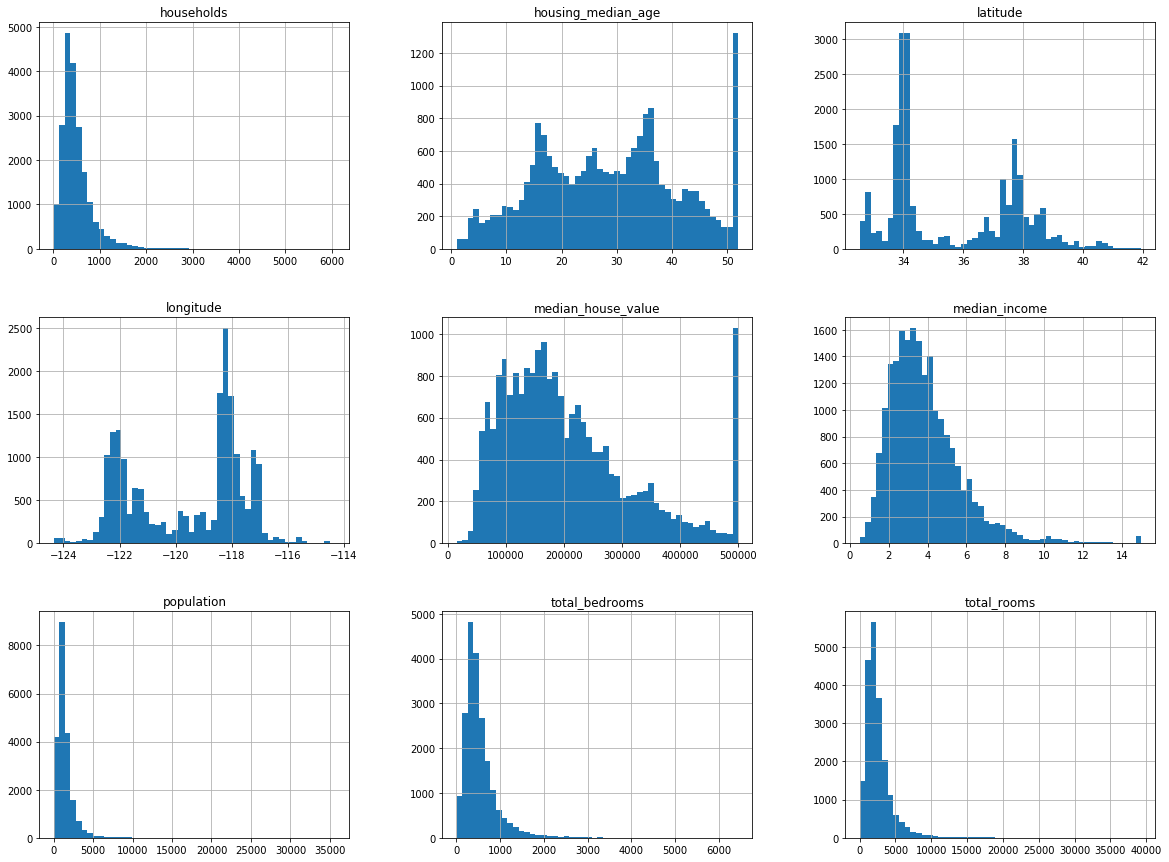

In [9]:
housing.hist(bins = 50, figsize = (20,15))
plt.show()

*이슈  
1. 중간소득(median income)이 US달러 단위가 아님  
2. 중간주택연도(housing median age)와 중간주택가격(median house value)은 최대값과 최솟값을 제한  
3. 변수들간의 스케일이 서로 많이 다름  
4. 대부분이 왼쪽으로 쏠려있는 왜곡된 분포(이러한 형태는 패턴을 찾기 힘듬, 종모양이 좋음)  

## 2. 테스트 셋 만들기  

데이터를 자세하게 살펴보기 전, 테스트 셋을 분리해놓은 후에 작업해야 과대적합 등을 방지할 수 있다.  

### 2-1. 함수 정의를 통한 샘플링  

In [10]:
np.random.permutation(10)

array([5, 0, 9, 2, 8, 3, 1, 4, 6, 7])

무작위로 샘플을 추출해 test와 train셋을 만드는 함수를 정의

In [11]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))  # input 데이터의 인덱스 무작위로 섞기
    test_set_size = int(len(data)*test_ratio)            # test셋의 사이즈 설정
    test_indices = shuffled_indices[:test_set_size]      # test셋 사이즈만큼 인덱스 가져오기
    train_indices = shuffled_indices[test_set_size:]     # train셋 사이즈만큼 인덱스 가져오기
    return data.iloc[train_indices], data.iloc[test_indices]  #test,train셋 인덱싱 및 추출

여기서 `np.random.permutation()`함수는 0부터 입력값의 정수값-1 까지(10은 0~9까지)의 정수들을 무작위로 섞어서 반환해주는 함수이다, 

In [12]:
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set),"train", " + ",len(test_set),"test" )

16512 train  +  4128 test


이러한 데이터셋 분리과정은 random추출이므로 계속적인 실행에 따라 데이터셋이 변경되게 되어 결국 모든 데이터를 보게 될수도 있다.  
이를 방지하기 위해 몇 가지 방법을 생각해 볼 수 있다.  

1. `np.random.seed(42)`를 통해 난수 발생기의 초깃값 설정(42는 특별한 의미는 없음)  
2. test셋을 처음에 뽑고 내보낸 후 다음에 불러들이는 방법
3. 샘플의 id를 이용한 분리방법  

1,2는 데이터가 계속 업데이트 되는 상황이라면 문제가 생긴다. 하지만 3번은 데이터가 고유 id를 가지고 있다면, 업데이트 되더라도 테스트 셋이 동일하게 유지되게 할 수 있다.

In [13]:
from zlib import crc32
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_ : test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

즉, 현재 불러온 housing 데이터는 id가 없으므로 index를 id값으로 만들고, 추가로 데이터가 업데이터 될때 해시값을 계산하여 조건(test_set_check함수)을 만적하는 경우만 test셋으로 추출될 수 있도록 하자.  

In [14]:
housing_with_id = housing.reset_index()

In [15]:
housing_with_id.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [16]:
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

그래도 id가 index번호로 하는 것 보다는, id를 위도와 경도를 이용해 만들어 다시 추출하자.    

In [17]:
housing_with_id['id'] = housing['longitude'] * 1000 + housing['latitude']
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

### 2-2. scikit-learn 라이브러리 활용  & 계층적 샘플링

In [18]:
from sklearn.model_selection import train_test_split

사이킷런에서 제공하는 `train_test_split`함수는 앞에서 수동으로 만든 `split_train_test`함수와 비슷하지만 두가지 차이가 있다.  
1. `random_state`옵션으로 난수 초깃값을 지정할 수 있다.  
2. row수가 같은 여러 개의 데이터셋을 넘겨서 같은 인덱스를 기반으로 나눌 수 있다.  

In [19]:
train_set, test_set = train_test_split(housing, test_size = 0.2, random_state=42)

> 계층적 샘플링(stratified sampling)  
> 대표성을 가지는 샘플 추출을 위해서는 계층(범주)을 잘 반영해야 한다.  
> 예를들어 남자가 52%, 여자가 48%인 전체인구의 1000명 샘플은 이 비율을 반영해서 샘플링되어야 편향을 막을 수 있다.  

여기서 housing 데이터의 중간소득(median_income)이 중요한 변수라고 생각해보자. 이 연속형 변수인 중간소득을 적절한 계층으로 나누고, 이 계층을 잘 반영하도록 샘플링을 해야한다.  
다시 중간소득(median_income)변수의 히스토그램을 보자.  

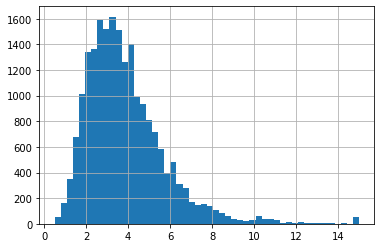

In [20]:
housing['median_income'].hist(bins = 50)
plt.show()

연속형변수를 범주화 할때는, 각 계층(범주)별 충분한 데이터셋의 샘플이 존재해야 한다.  
즉, 너무 많은 계층으로 나누면 안된다는 의미이다.  

In [24]:
housing["income_cat"] = np.ceil(housing['median_income'] / 1.5)
housing["income_cat"].where(housing['income_cat'] < 5, 5.0, inplace=True)

여기서 사용된 함수에 대해 알아보자.  
1. `np.ceil()`함수는 각 값들을 올림(-4.2는 -4, 5.2는 6)해주는 함수이다. 즉, 1.5로 나누어 올림해줌으로써 계층을 줄이는 역할을 해주는 것이다.(이 부분은 여러가지 방법이 있을 수 있다.)  
2. `Series.where()`함수는 `np.where`함수와 비슷한 기능을 하는데, 조건을 만족하는 값들은 기존 Series값, 만족하지 않으면 두번째 입력값을 대입해준다.(즉, 5이상은 5로 합쳐준 것이다.)  

다시 히스토그램을 보자.  

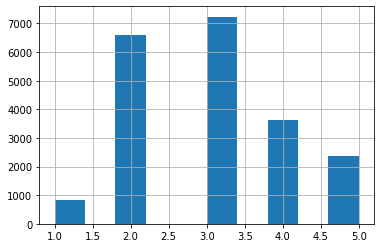

In [25]:
housing['income_cat'].hist()
plt.show()

계층들이 왼쪽으로 쏠려있다가, 종모양의 형태를 가진 분포로 계층화가 되었음을 알 수 있다.  

In [26]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size = 0.2, random_state= 42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

의도대로 계층화 샘플링이 잘 되었는지 확인해보자.  

In [27]:
housing["income_cat"].value_counts() / len(housing)  # 각 계층들의 비율

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [28]:
strat_train_set["income_cat"].value_counts() / len(strat_train_set)

3.0    0.350594
2.0    0.318859
4.0    0.176296
5.0    0.114402
1.0    0.039850
Name: income_cat, dtype: float64

In [29]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

적절히 비율을 잘 반영하고 있다!   
이제 계층화를 완료했으니, 만들었던 income_cat 변수를 삭제하자.  

In [30]:
for i in (strat_train_set, strat_test_set):
    i.drop("income_cat", axis=1, inplace=True)

## 3. 데이터 탐색(EDA)과 시각화(Visualization)  

앞에서 train, test셋을 분리하는 작업을 완료했으니, 이제 train셋을 이용해서 앞으로 작업을 한다.  

In [31]:
housing = strat_train_set.copy()

In [32]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN


### 3-1. 지리적 데이터 시각화  

캘리포니아 주택 구역의 위경도 좌표를 이용해 뿌려보자.  

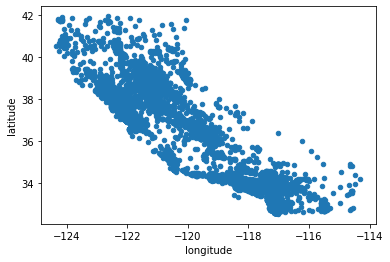

In [33]:
# 판다스 내장 그래프도구 활용
housing.plot(kind='scatter', x="longitude", y="latitude")

`alpha`옵션을 활용하면 점들이 밀집된 영역을 잘 보여준다.  
값이 작을수록 더 좁은 범위로 밀집된 지역, 값이 클수록 커버리지를 넓혀 대략적으로 보여준다.  

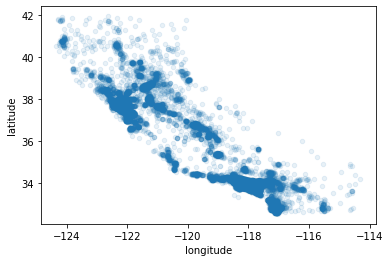

In [34]:
housing.plot(kind='scatter', x="longitude", y="latitude", alpha=0.1)

좀 더 직관적인 패턴 관찰을 위해, 매개변수와 옵션을 추가해보자.  
s는 매개변수의 값이 클수록 점의 크기를 조절해 주는 매개변수이고,  
c는 매개변수의 값에 따라 색을 다르게 지정해 주는 매개변수이다.  
즉, 위경도와 2가지 변수를 한번에 시각화함으로써 어떤 패턴을 발견할 수 있도록 한다.  

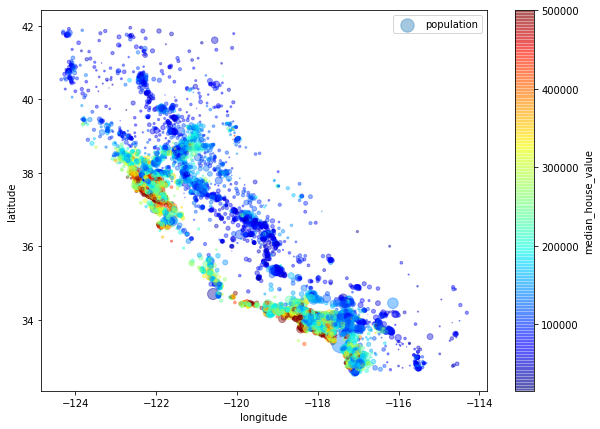

In [35]:
housing.plot(kind='scatter', x="longitude", y="latitude", alpha=0.4,
            s = housing['population'] / 100, label ="population", figsize=(10,7),
            c = "median_house_value", cmap = plt.get_cmap("jet"), colorbar=True, sharex=False)

그래프를 관찰해보면 주택가격은 바다와 인접하거나 인구밀도가 높은 지역일 수록 높게 나타나는 것을 확인할 수 있다.  
이러한 특성은 군집(clustering)분석을 이용해 볼 수도 있을 것 같다.  

### 3-2. 상관관계 조사  

각 변수간의 상관계수는 `corr()`함수를 통해 간단하게 확인할 수 있다.  

In [36]:
corr_matrix = housing.corr()
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105848,0.048871,0.076598,0.108030,0.063070,-0.019583,-0.047432
latitude,-0.924478,1.000000,0.005766,-0.039184,-0.072419,-0.115222,-0.077647,-0.075205,-0.142724
housing_median_age,-0.105848,0.005766,1.000000,-0.364509,-0.325047,-0.298710,-0.306428,-0.111360,0.114110
total_rooms,0.048871,-0.039184,-0.364509,1.000000,0.929379,0.855109,0.918392,0.200087,0.135097
total_bedrooms,0.076598,-0.072419,-0.325047,0.929379,1.000000,0.876320,0.980170,-0.009740,0.047689
population,0.108030,-0.115222,-0.298710,0.855109,0.876320,1.000000,0.904637,0.002380,-0.026920
households,0.063070,-0.077647,-0.306428,0.918392,0.980170,0.904637,1.000000,0.010781,0.064506
median_income,-0.019583,-0.075205,-0.111360,0.200087,-0.009740,0.002380,0.010781,1.000000,0.687160
median_house_value,-0.047432,-0.142724,0.114110,0.135097,0.047689,-0.026920,0.064506,0.687160,1.000000


그 중에서도 중간주택가격(median_house_vale)과 가장 상관관계가 높은 변수는 무엇인지 확인해보자.  

In [37]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

상관관계는 선형성 가정을 전제로 하기 때문에, 얼마나 선형적이냐에 대한 추정이다. 즉, 비선형적인 관계에 있는 변수라면 완전독립이 아님에도 상관계수가 0일 수 있다.  
따라서 산점도 그림과 함께 보는 것이 중요하다.  

`pd.plotting.scatter_matrix()`함수는 산점도 매트릭스와, 각 변수의 히스토그램을 제공해 준다.  
`diagonal`옵션을 통해 히스토그램 외에도 대각선에 다른 그래프를 그릴 수 있다.  

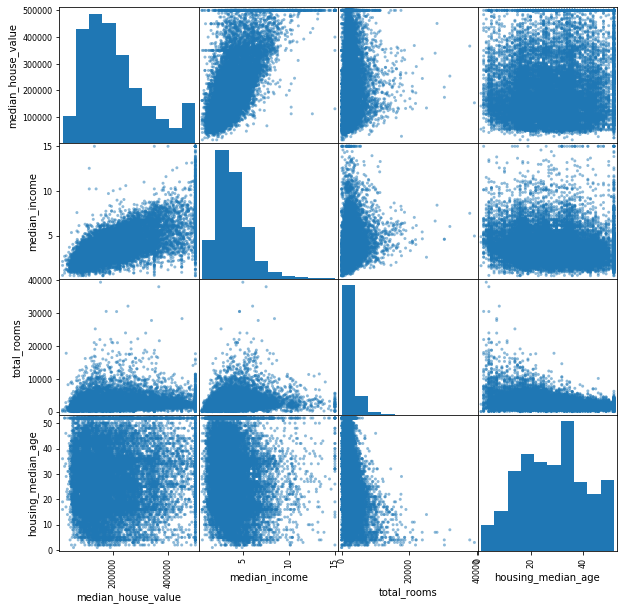

In [38]:
attributes = ["median_house_value","median_income", "total_rooms","housing_median_age"]
pd.plotting.scatter_matrix(housing[attributes], figsize = (10,10))
plt.show()

역시 중간주택가격(median_house_value)과 중간소득(median_income)은 강한 상관관계를 나타낸다.  

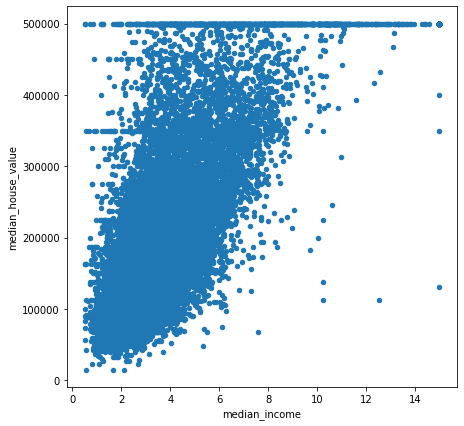

In [39]:
housing.plot(kind="scatter", x = "median_income", y= "median_house_value", figsize=(7,7))

주목할 만한 점  
1. 양의 상관관계가 매우 강하다.  
2. 상한선(500000)으로 인해 수평선이 보이고, 이외에도 450000와 350000, 280000 등에서도 볼 수 있다.  
이러한 이상치들을 처리해주어야 한다.  

### 3-3. 파생변수 생성해보기  

변수 total_rooms와 total_bedrooms는 그 자체 보다는,  
변수의 조합을 통해 가구당 방의 개수, 침대의 비율 등이 적절해보인다.  

In [40]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN


In [41]:
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']     # 가구당 방의 수
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']   # 방 1개당 침대의 수
housing['population_per_household'] = housing['population'] / housing['households'] # 가구당 인구 수

다시 상관관계를 보자.  

In [43]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

개별 변수보다는 파생변수가 조금 더 상관계수가 높게 나타난다.(특히 침대/방의 비율 -0.259984)  
이러한 과정들은 한번의 탐색을 통해 결정될 수 없으며, 분석 결과를 도출 한 후 다시 돌아와야하는 반복적 과정이다.  

## 4. 머신러닝 알고리즘을 위한 데이터 준비  

종속변수(median_house_value)와 독립변수를 분할한다.  

In [99]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"]

### 4-1. 결측치 처리 : 판다스 활용    

앞서도 확인했지만 total_bedrooms 변수에 결측값이 존재했었다.  
이 값을 중앙값(median)으로 대체해 보자.  

In [100]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 9 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16354 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
ocean_proximity       16512 non-null object
dtypes: float64(8), object(1)
memory usage: 1.9+ MB


In [50]:
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median, inplace=True)

### 4-1. 결측치 처리 : 사이킷런 활용 `SimpleImputer`      

In [101]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

중앙값은 숫자형 변수만 계산이 가능하므로 문자형 변수를 제거한 후 시행해야한다.  

In [102]:
housing_num = housing.drop("ocean_proximity", axis=1)

In [103]:
imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

imputer는 각 변수들의 중앙값(median)을 계산하여 statistics_ 속성에 저장해준다.  
이렇게 결측값이 있는 변수만이 아니라 imputer에 모든 숫자형 변수의 median을 저장해 놓아, 추후에 자동적으로 처리되게 도와준다.  

In [104]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

`transform()`함수를 적용해 주면 기존 데이터의 결측값에 계산했던 해당 변수의 중앙값(median)을 대체하여 변환된 데이터셋을 다시 반환해 준다.  

In [110]:
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns = housing_num.columns, index = list(housing.index.values))
housing_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 8 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16512 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
dtypes: float64(8)
memory usage: 1.1 MB


### 4-2. 문자형, 범주형 변수 다루기 : `Seriese.factorize()`

housing 데이터의 유일한 문자형 변수 ocean_proximity를 살펴보자.  

In [117]:
housing_cat = housing["ocean_proximity"]
housing_cat.head(10)

17606     <1H OCEAN
18632     <1H OCEAN
14650    NEAR OCEAN
3230         INLAND
3555      <1H OCEAN
19480        INLAND
8879      <1H OCEAN
13685        INLAND
4937      <1H OCEAN
4861      <1H OCEAN
Name: ocean_proximity, dtype: object

판다스의 `factorize()`함수를 통해 카테고리를 정수값으로 매핑해주는 작업을 수행할 수 있다.  
이 함수를 적용하면, 시리즈의 각원소마다 매핑된 정수값 배열과, 카테고리 리스트를 반환한다.  
매핑된 정수값은 카테고리의 순서를 따라 0부터 매핑된다.  

In [118]:
housing_cat.factorize()

(array([0, 0, 1, ..., 2, 0, 3], dtype=int64),
 Index(['<1H OCEAN', 'NEAR OCEAN', 'INLAND', 'NEAR BAY', 'ISLAND'], dtype='object'))

In [120]:
housing_cat_encoded, housing_categories = housing_cat.factorize()

### 4-2. 문자형, 범주형 변수 다루기 : `OneHotEncoder`

사실 위에서 범주형을 카테고리로 변환해주긴 했지만, 0~4값이 가지는 크기는 의미가 없기 때문에 잘못된 학습을 할 수 있다.  
사이킷런에서 제공하는 `OneHotEncoder`를 이용해 더미변수(0또는 1의 값)로 만들어 사용하는 것이 좋다.  

In [121]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(categories='auto')
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [126]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

즉, 한 변수가 5개의 범주를 가지고 있으므로, 5개의 열로 분할한 행렬을 만들고 하나의 행에 하나의 1값만 존재한다.  

이렇게 문자형을 숫자형으로, 숫자형을 one-hot 벡터로 변환하는 작업을 `CategoricalEncoder`을 사용하여 한번에 처리할 수 있다.  
2차원 배열이 필요하기 때문에 대괄호를 두개 씌워 데이터프레임 형태로 가져와야한다.  

In [158]:
housing_cat = housing[['ocean_proximity']]

In [166]:
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [167]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [ ]:
인코더가 학습한 후 카테고리 목록을 살펴볼 수 있다.

In [168]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [ ]:
이걸 다시 데이터프레임으로 만들어보면  

In [172]:
one_hot_df = pd.DataFrame(housing_cat_1hot.toarray(), columns=cat_encoder.categories_)
one_hot_df.head()

,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0


사실 이러한 작업은 housing 데이터가 이미 판다스 데이터프레임 객체이기 때문에 `pd.get_dummies()`함수를 통해 한번에 작업할 수 있다.  

In [176]:
pd.get_dummies(housing_cat).head()

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
17606,1,0,0,0,0
18632,1,0,0,0,0
14650,0,0,0,0,1
3230,0,1,0,0,0
3555,1,0,0,0,0


### 4-3. 나만의 변환기 만들기  

내가 만든 변환기를 사이킷런에서 제공하는 class와의 상속을 통해 연동한다.  

In [207]:
from sklearn.base import BaseEstimator, TransformerMixin

# get the right column indices: safer than hard-coding indices 3, 4, 5, 6
rooms_ix, bedrooms_ix, population_ix, household_ix = [
    list(housing.columns).index(col)
    for col in ("total_rooms", "total_bedrooms", "population", "households")]

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kwargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

### 4-4. 변수 스케일링(scaling)  

현재 갖고 있는 데이터들은 스케일(값의 범위)의 차이가 있으므로 이를 조정해줄 필요가 있다.  
예측변수인 중간주택가격(median_house_value)의 스케일링은 불필요하다.  

In [178]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000
mean,-119.575834,35.639577,28.653101,2622.728319,534.973890,1419.790819,497.060380,3.875589
std,2.001860,2.138058,12.574726,2138.458419,412.699041,1115.686241,375.720845,1.904950
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566775
50%,-118.510000,34.260000,29.000000,2119.500000,433.000000,1164.000000,408.000000,3.540900
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.250000,602.000000,4.744475
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100


1. min-max 스케일링 : (관측값 - 최소값) / (최대값 - 최소값)  


- 모든 값을 0~1 사이로 조정  
- 사이킷런 : `MinMaxScaler`  

In [200]:
from sklearn.preprocessing import MinMaxScaler

scale1 = MinMaxScaler()
scale1.fit(housing[['households']])
scale1_households = scale1.transform(housing[['households']])
scale1_households

array([[0.06292009],
       [0.02072442],
       [0.08588499],
       ...,
       [0.14245706],
       [0.0660941 ],
       [0.11893204]])

2. 표준화 : (관측값 - 평균) / 표준편차  


- 표준화 값들은 평균이 0, 분산이 1이 된다.  
- 범위의 상한과 하한이 없고, 이상치에 영향을 덜받는 경향  
- 사이킷런 : `StandardScaler`  

In [201]:
from sklearn.preprocessing import StandardScaler

scale2 = StandardScaler()
scale2.fit(housing[['households']])
scale2_housholds = scale2.transform(housing[['households']])
scale2_housholds

array([[-0.42069842],
       [-1.02222705],
       [-0.0933178 ],
       ...,
       [ 0.71315642],
       [-0.37545069],
       [ 0.3777909 ]])

> 주의 : 모든 변환기에서 스케일링은 전체 데이터가 아니라 훈련 데이터에 대해서만 `fit()`을 적용하고, 이걸로 훈련, 테스트 세트에 `transform()`을 사용해야 한다.  

### 4-5. 파이프라인 만들기 : `Pipeline`

앞에서 수행했던 여러가지 변환 단계는 실제 프로젝트에서 정확하고 순서대로 실행되어야 한다.  
이러한 작업을 도와주는 `Pipeline`클래스가 있다.  

In [213]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

여기서 input데이터로 들어간 housing_num은 숫자형변수만 남겨놓은 데이터였다.  
Pipeline을 이용해서 순서대로,  
결측값의 중앙값 대체 -> 파생변수 생성 -> 표준화 를 수행한다.  

하지만 숫자형과 문자형을 분리하지 말고, `ColumnsTransformer`을 이용해 애초에 전체 데이터를 입력값으로 넣어주면 알아서 분리해주고 작업을 수행하도록 파이프라인을 만들어 보자.  

In [332]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [333]:
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

이와 같이 앞에서 계속 정제했던 작업들을 하나로 모았다.  
- 문자형과 숫자형 변수 분리,  
- 숫자형에 대해서는 결측값 대체, 파생변수, 표준화
- 문자형에 대해서는 one-hot 인코딩
- 다시 합쳐서 최종 훈련 데이터 셋을 array로 반환. 

이 모든 작업을 정확하고 순서대로 처리할 수 있게 만든 것이다.  

## 5. 모델 선택과 훈련  

### 5-1. 선형 회귀 모델(Linear Regression Model)  

준비된 훈련데이터와 아까 분리해두었던 예측변수(중간주택가격)를 모델에 넣고 적합시켜보자.  

In [244]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

일단은 훈련데이터 셋의 일부에 한번 적용을 해보자.  

In [251]:
some_data = housing.iloc[:5]
some_labels = housing_labels[:5]
some_data_prepared = full_pipeline.transform(some_data)  # 이럴때 굉장히 유용한 pipeline!
print("적합값 :",lin_reg.predict(some_data_prepared))    # 모델로 예측한 적합값
print("실제값 :", list(some_labels))                     # 실제 예측변수(y)값

적합값 : [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]
실제값 : [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


눈으로만 봐도 적합값과 실제값의 차이가 굉장히 많이 나는 것을 알 수 있다.(모델의 예측력이 많이 떨어짐)  

사이킷런의 `mean_square_error`함수를 이용해 평균제곱오차를 측정해보자.  

In [252]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

여기서 mse는 평균제곱오차로, (예측값-실제값)^2의 평균이고, Rmse는 이를 제곱근을 씌운 것이다.  
즉, 두 값의 차이가 얼마나 많이나는지 확인해볼 수 있는 손실함수(loss function)중 하나이다.  

In [260]:
housing_labels.describe()

count     16512.000000
mean     206990.920724
std      115703.014830
min       14999.000000
25%      119800.000000
50%      179500.000000
75%      263900.000000
max      500001.000000
Name: median_house_value, dtype: float64

예측변수인 중간주택가격은 대부분 120000(1분위수)~265000(3분위수)사이에 모여있는데, 예측오차(RMSE)가 68628이라는 것은 만족스럽지 못하다.  
과소적합되었다고 할 수 있다.  

이럴때는 두가지 방법이 있다.  

1. 모델의 개선(튜닝, 앙상블 등)  
2. 훈련데이터에 더 좋은 변수를 추가  

일단은 의사결정나무 `DecisionTreeRegressor`로 훈련시켜 더 복잡하고 정교한 모델을 만들어보자.  

In [288]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [289]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

헐?.. 이번엔 완벽하게 예측을 한다고 나온다.  
훈련데이터를 과대적합한 것으로 보이지만, 테스트셋에 검증하기 전까지는 확신할 수 없다.  
하지만 테스트셋은 모델이 결정되기 전까지는 건들지 않는 것이 좋기때문에, 일부의 훈련세트로 훈련하고 검증하는 과정이 필요하다.  

### 5-2. 교차 검증(cross-validation)을 통한 평가  

앞에서 사용했던 `train_test_split`함수를 이용해 훈련세트를 계속 분할해 나갈 수도 있지만, 주로 사용되는 K-fold 교차검증이 있다.  

In [290]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, 
                        scoring = "neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

사이킷런의 `cross_val_score`기능은 scoring 옵션에 비용함수가 아닌 (클수록 좋은)효용함수를 기대한다.  
따라서 MSE의 음수값인 neg_mean_squared_error함수를 사용해야한다.  

또한 입력인자는 모델, 독립변수 셋, 예측변수 셋, 매개변수scoring, 몇겹(fold)으로 분할할지가 들어간다.  

In [291]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [69129.43040747 67347.40533873 70381.49122807 69104.29462832
 71739.90411422 75353.76798175 70506.54282334 71061.49342486
 76917.94724276 69794.76453711]
Mean: 71133.70417266262
Standard deviation: 2772.412117850753


이렇게 보니 결정트리 모델로 예측했을때는 평균 71133 +- 2772(표준편차)이므로 썩 좋아보이진 않는 것 같다.  
이 교차검증법을 처음에 했던 선형회귀에도 적용해보자.  

In [292]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                            scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard deviation: 2731.6740017983425


선형회귀의 경우는 표준편차가 2731로 더 적으므로 성능이 결정트리보다는 낫다.  

마지막으로 여러 다른 모델을 모아 하나의 모델을 만드는 일종의 '앙상블 학습'이라고 할 수 있는 랜덤포레스트 모델도 시도해보자.  

In [295]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(n_estimators=10)
forest_reg.fit(housing_prepared, housing_labels)
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, 
                        scoring = "neg_mean_squared_error", cv=10)

forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [52766.86541538 50836.76031927 53249.18904944 54577.35648644
 53049.67126162 56249.13126274 51330.3427302  49964.11175115
 55079.71833681 52694.12258545]
Mean: 52979.72691985169
Standard deviation: 1851.012689010751


랜덤포레스트 모델은 매우 성능이 뛰어나다!  
하지만, 실제값보다 적합값이 현저하게 낮게 나타나고 있어, 이 모델 역시 훈련셋에 과대적합되어 있는 것 같다.  
이 단계에서는 개별 모델간의 하이퍼파라미터 조정에 많은 시간을 사용하는 것 보다는 가능성 있는 2~5개 정도의 모델을 선정하는 것이 목표이다.  

> 참고로 실험한 모델을 저장해두면 쉽게 모델을 복원할 수 있다.  
> 파이썬의 `pickle`이나 `sklearn.externals.joblib`을 이용할 수 있다.  

In [ ]:
from sklearn.externals import joblib

joblib.dump(my_model,"my_model.pkl")
# ... 그리고 나중에 다시 불러올 때,
my_model_loaded = joblib.load("my_model.pkl")

## 6. 모델 세부 튜닝  

### 6-1. 그리드 탐색 : `GridSearchCV`

`GridSearchCV`를 사용하면 가능한 모든 하이퍼파라미터 조합에 대해 교차 검증을 사용해 알아서 평가를 해준다.  
랜덤포레스트 모델의 최적 파라미터 조합을 탐색해보자.  

In [296]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # 첫 딕셔너리는 12(3 x 4)번의 조합
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # 두번째 딕셔너리는 6(2×3)번 의 조합 + bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# k-fold는 5겹이므로, 총 90((12+6)*5)번의 학습을 시행한다.  
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'max_features': [2, 4, 6, 8],
  

꽤 오랜 시간이 걸리지만 90번의 학습을 모두 자동으로 수행하게 되며, 아래와 같이 최적의 조합을 찾을 수 있다.  

In [297]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

8과 30은 모두 첫 딕셔너리 하이퍼파라미터의 최대값이므로 더 향상될 가능성이 있어보인다.  
이럴땐 더 큰값으로 넣고 시행해 봐야한다.  

직접 추정기에 접근해 어떤 파라미터가 사용됐는지 볼 수 있다.  

In [299]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=8, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

평가점수도 확인할 수 있다.  

In [306]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63669.05791727153 {'max_features': 2, 'n_estimators': 3}
55627.16171305252 {'max_features': 2, 'n_estimators': 10}
53384.57867637289 {'max_features': 2, 'n_estimators': 30}
60965.99185930139 {'max_features': 4, 'n_estimators': 3}
52740.98248528835 {'max_features': 4, 'n_estimators': 10}
50377.344409590376 {'max_features': 4, 'n_estimators': 30}
58663.84733372485 {'max_features': 6, 'n_estimators': 3}
52006.15355973719 {'max_features': 6, 'n_estimators': 10}
50146.465964159885 {'max_features': 6, 'n_estimators': 30}
57869.25504027614 {'max_features': 8, 'n_estimators': 3}
51711.09443660957 {'max_features': 8, 'n_estimators': 10}
49682.25345942335 {'max_features': 8, 'n_estimators': 30}
62895.088889905004 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54658.14484390074 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59470.399594730654 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52725.01091081235 {'bootstrap': False, 'max_features': 3, 'n_estimators'

5겹의 교차검증을 평균한 점수(mean_score)와 총 18번의 경우의 수를 볼 수 있다.  

In [316]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.067451,0.003699,0.002987,1.397336e-05,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-3.837622e+09,-4.147108e+09,...,-4.053749e+09,1.519609e+08,18,-1.064113e+09,-1.105142e+09,-1.116550e+09,-1.112342e+09,-1.129650e+09,-1.105559e+09,2.220402e+07
1,0.217434,0.005090,0.008768,7.574205e-04,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-3.047771e+09,-3.254861e+09,...,-3.094381e+09,1.327046e+08,11,-5.927175e+08,-5.870952e+08,-5.776964e+08,-5.716332e+08,-5.802501e+08,-5.818785e+08,7.345821e+06
2,0.637718,0.010191,0.024131,1.454073e-03,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-2.689185e+09,-3.021086e+09,...,-2.849913e+09,1.626879e+08,9,-4.381089e+08,-4.391272e+08,-4.371702e+08,-4.376955e+08,-4.452654e+08,-4.394734e+08,2.966320e+06
3,0.102935,0.002914,0.002992,6.641573e-07,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-3.730181e+09,-3.786886e+09,...,-3.716852e+09,1.631421e+08,16,-9.865163e+08,-1.012565e+09,-9.169425e+08,-1.037400e+09,-9.707739e+08,-9.848396e+08,4.084607e+07
4,0.332926,0.004224,0.008180,3.972299e-04,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-2.666283e+09,-2.784511e+09,...,-2.781611e+09,1.268562e+08,8,-5.097115e+08,-5.162820e+08,-4.962893e+08,-5.436192e+08,-5.160297e+08,-5.163863e+08,1.542862e+07
5,0.992740,0.008862,0.025335,1.852385e-03,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-2.387153e+09,-2.588448e+09,...,-2.537877e+09,1.214603e+08,3,-3.838835e+08,-3.880268e+08,-3.790867e+08,-4.040957e+08,-3.845520e+08,-3.879289e+08,8.571233e+06
6,0.135464,0.004689,0.002986,1.532822e-05,6,3,NaN,"{'max_features': 6, 'n_estimators': 3}",-3.119657e+09,-3.586319e+09,...,-3.441447e+09,1.893141e+08,14,-9.245343e+08,-8.886939e+08,-9.353135e+08,-9.009801e+08,-8.624664e+08,-9.023976e+08,2.591445e+07
7,0.446622,0.008421,0.008584,7.989093e-04,6,10,NaN,"{'max_features': 6, 'n_estimators': 10}",-2.549663e+09,-2.782039e+09,...,-2.704640e+09,1.471542e+08,6,-4.980344e+08,-5.045869e+08,-4.994664e+08,-4.990325e+08,-5.055542e+08,-5.013349e+08,3.100456e+06
8,1.350788,0.008776,0.024541,2.715640e-03,6,30,NaN,"{'max_features': 6, 'n_estimators': 30}",-2.370010e+09,-2.583638e+09,...,-2.514668e+09,1.285063e+08,2,-3.838538e+08,-3.804711e+08,-3.805218e+08,-3.856095e+08,-3.901917e+08,-3.841296e+08,3.617057e+06
9,0.176742,0.003753,0.003598,4.758663e-04,8,3,NaN,"{'max_features': 8, 'n_estimators': 3}",-3.353504e+09,-3.348552e+09,...,-3.348851e+09,1.241864e+08,13,-9.228123e+08,-8.553031e+08,-8.603321e+08,-8.881964e+08,-9.151287e+08,-8.883545e+08,2.750227e+07


### 6-2. 그리드 탐색 : `RandomizedSearchCV`

앞의 `GridSearchCV`도 좋은 방법이지만, 조합의 수가 많아진다면 굉장히 비효율적이고 많인 비용이 들 것이다.  
이 `RandomizedSearchCV`는 모든 경우의 수 조합을 시도하지 않고 각 반복마다 '임의의 수'를 대입하여 지정한 횟수만큼 평가한다.  

> 장점1 : 1000회 랜덤 탐색을 반복시키면 각기다른 1000개의 파라미터값을 탐색한다.  
> 장점2 : 단순히 반복횟수 조절만으로도 하이퍼파라미터 탐색에 투입할 컴퓨팅 자원 제어 가능  

### 6-3 앙상블 방법  

결정트리의 앙상블인 랜덤 포레스트가 결정트리 하나보다 더 성능이 좋은 것 처럼, 모델의 그룹(또는 앙상블)이 최상의 단일 모델보다 더 나은 성능을 발휘할 때가 많다.  

### 6-4 최상의 모델과 오차분석  

최상의 모델을 분석하면 문제에 대한 통찰을 얻는 경우가 생긴다.  
아까 그리드탐색을 통해 랜덤포레스트의 최적의 하이퍼파라미터 조합을 찾았었다.  
이 모델이 정확한 예측을 만들기 위한 각 특성의 상대적 중요도를 살펴보자.  

In [318]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03])

이름을 붙여보자  

In [319]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
#cat_encoder = cat_pipeline.named_steps["cat_encoder"] # old solution
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.36615898061813423, 'median_income'),
 (0.16478099356159054, 'INLAND'),
 (0.10879295677551575, 'pop_per_hhold'),
 (0.07334423551601243, 'longitude'),
 (0.06290907048262032, 'latitude'),
 (0.056419179181954014, 'rooms_per_hhold'),
 (0.053351077347675815, 'bedrooms_per_room'),
 (0.04114379847872964, 'housing_median_age'),
 (0.014874280890402769, 'population'),
 (0.014672685420543239, 'total_rooms'),
 (0.014257599323407808, 'households'),
 (0.014106483453584104, 'total_bedrooms'),
 (0.010311488326303788, '<1H OCEAN'),
 (0.0028564746373201584, 'NEAR OCEAN'),
 (0.0019604155994780706, 'NEAR BAY'),
 (6.0280386727366e-05, 'ISLAND')]

이 정보를 바탕으로 덜 중요한 변수들을 제외할 수 있다.(예를들어 ocean_proximity카테고리 중 하나만 실제로 유용하다.)  

이렇게 모델을 만들고 끝나는게 아니라 왜 모델이 그렇게 만들어졌고, 어디서 오차가 많이 생겼는지 고민하고 모델을 뜯어보는 작업이 굉장히 중요하다.  

### 6-5 테스트 세트로 시스템 평가하기  

이제 튜닝도 어느정도 했겠다, 드디어 맨처음 분리해 놓았던 테스트 셋을 꺼내 평가를 해보자.  

In [334]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [335]:
final_rmse

47730.22690385927